## Welcome Paul

This is a notebook made specifi

In [13]:
import re
import torch
import torch.nn as nn
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, random_split
from copy import deepcopy
from torch import cuda
import copy
from tqdm import tqdm
from torch.optim import AdamW
from codecarbon import track_emissions


Dataloader (SpeechDataset class)

In [2]:
SEED = 42  # defining a seed to facilitate replication
device = 'cuda' if cuda.is_available() else 'cpu'

/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir, load_method):
        """
        :flac_dir
        """
        self.audio_path_list = sorted(self.find_files(flac_dir)) 
        methods = {"librosa": self.librosa_flac2melspec, "soundfile": self.sf_loader, "torchaudio": self.torch_flac2melspec}
        self.labels = {"es": 0, "en": 1, "de": 2}
        self.languages = {v: k for k, v in self.labels.items()}
        self.chosen_method = methods[load_method]
        
        
    def __len__(self):
        return len(self.audio_path_list)

    def __getitem__(self, index):
        audio_file = self.audio_path_list[index]  
        label = self.labels[self.get_label(audio_file)]
        spectro, _ = self.chosen_method(audio_file)  # _ is fs
        #spectro = torch.from_numpy(spectro)
        #spectro = spectro.unsqueeze(0)
        return spectro, label

    def find_files(self, directory, pattern=".flac"):
        """
        Recursive search method to find files. Credit to Paul Magron and Andrea de Marco
        for OG method
        """

        regexFlac = re.compile(rf'/.*fragment\d+\{pattern}$') 
        files = [f.path for f in os.scandir(directory) if regexFlac.search(f.path)]  # ends with does not like regex
        return files
    
    def monolingual_path_list(self, language, gender):
        """
        Input: string ('en'|'de'|'es')
        Output: audio path list only containing file names of the chosen language
        """
        #r = re.compile(rf'.*\/{language}_{gender}.*fragment\d+\.flac') 
        r = re.compile(rf'.*\/{language}.*fragment\d+\.flac') 
        newlist = list(filter(r.match, self.audio_path_list))
        return newlist
    
    def get_label(self, path):
        labelRegex = re.compile(r"(es|en|de)_.*.flac")
        patterns = labelRegex.findall(path)
        assert len(patterns) == 1
        return patterns[0]

    def torch_flac2melspec(self, file_path):
        pass  # commenting option to avoid pip issues on colab
        #waveform, sample_rate = torchaudio.load(file_path, normalize=True)
        #transform = T.MelSpectrogram(sample_rate)        
        #return transform(waveform), sample_rate
        
    def sf_loader(self, file_path):
        with open(file_path, "rb") as f:
            data, samplerate = sf.read(f)
        return data, samplerate

    def librosa_flac2melspec(self, file_path, n_mels=64, melspec_size=512, visual=False):
        """
        the librosa method we are using atm
        """
        sig, fs =  librosa.load(file_path, sr=None)
        sig /= np.max(np.abs(sig), axis=0)
        n_fft = melspec_size
        hop_length = int(n_fft/2)

        # padding signal if less than a second
        if len(sig) < fs:
            padded_array = np.zeros(fs)
            padded_array[:np.shape(sig)[0]] = sig
            sig = padded_array

        melspec = librosa.feature.melspectrogram(y=sig, sr=fs,
                                                 center=True, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)


        if visual:
            self.plotmelspec(melspec, fs, hop_length)

        melspec = librosa.power_to_db(melspec, ref=1.0)
        melspec /= 80.0  # highest db...
        melspec = self.checkmelspec(melspec)
        return melspec, fs

    def checkmelspec(self, melspec, n_mels=64):
        """
        this method works with librosa

        """
        if melspec.shape[1] < n_mels:  # n_mels
            shape = np.shape(melspec)
            padded_array = np.zeros((shape[0], n_mels)) - 1
            padded_array[0:shape[0], :shape[1]] = melspec
            melspec = padded_array
        return melspec

    def plotmelspec(self, melspec, fs, hop_length, show=False):
        plt.figure(figsize=(8, 6))
        plt.xlabel("Time")
        plt.ylabel("Mel-Frequency")
        librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                                 y_axis="mel", fmax=fs/2, sr=fs,
                                 hop_length=hop_length, x_axis="time")
        plt.colorbar(format="%+2.0f db")
        plt.title("Mel Spectogram")
        plt.tight_layout()
        if show:
            plt.show()
        plt.close()  # to close windows and fix warning!

Function to get balanced subset:

In [4]:
def get_balanced_subset(train_data, n, gender):
    '''
    Creates subset with equal amounts of data from each language
    Input: instance of class Speechdataset, desired number of files per language (int) 
    Output: balanced subset (torch.utils.data.dataset.ConcatDataset)
    '''
    #create new instances for each language
    en=deepcopy(train_data)
    es=deepcopy(train_data)
    de=deepcopy(train_data)
    
    
    #modify the audio_path_list to only include paths to files of a single language
    en.audio_path_list=en.monolingual_path_list('en', gender)
    es.audio_path_list=es.monolingual_path_list('es', gender)
    de.audio_path_list=de.monolingual_path_list('de', gender)

    #extract equally sized subsets from each monolingual dataset
    en_sub = Subset(en, torch.arange(n))
    es_sub = Subset(es, torch.arange(n))
    de_sub = Subset(de, torch.arange(n))
    
    subset=en_sub+de_sub+es_sub #concatenate subsets
    return subset

utils.py

In [5]:
# https://debuggercafe.com/saving-and-loading-the-best-model-in-pytorch/

def evaluation(model, val_data, loss_fn):

    device = 'cuda' if cuda.is_available() else 'cpu'

    model.eval()
    with torch.no_grad():
        correct = 0
        loss = 0
        total = 0
        for spectra, labels in val_data:

            spectra = spectra.unsqueeze(1)
            spectra = spectra.to(device)
            labels = labels.to(device)
            preds = model(spectra)
            vals, labels_preds = torch.max(preds.data, 1)  # preds.data == preds? vals are not needed
            total += labels.size(0)  # same as shape[0], what's more pytorch-like?
            correct += (labels_preds == labels).sum().item()
            # loss
            err = loss_fn(preds, labels)
            loss += err.item()
        total_loss = loss / len(val_data)
    return correct / total * 100, total_loss

def visualize(epochs, tr_loss, val_loss, save=False):

    fig = plt.figure()
    train, = plt.plot(torch.arange(epochs) + 1, tr_loss, '-og', label="Train")  
    valid, = plt.plot(torch.arange(epochs) + 1, val_loss, '-or', label="Valid")  
    plt.xlabel('Epochs')
    plt.ylabel("Loss")    
    plt.legend(handles=[train, valid])
    plt.title('Loss over epochs')
    if save:
        fig.savefig("Loss_over_epochs.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig)

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'model_output/final_speech_cnn.pth')

plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    #def __init__(self, best_valid_loss=float('inf')):
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        #self.path = "./model_output/best_speech_cnn.pth"
        self.path = "model_output/best_speech_cnn.pth"
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion}, self.path)

CNNSpeechClassifier Modules

In [6]:
class CNNSpeechClassifier(nn.Module):

    def __init__(self, channel_inputs, num_channels1, num_channels2, kernel_size, kernel_pool, padding, num_classes):
        num_channels3 = 64
        super(CNNSpeechClassifier, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(channel_inputs, num_channels1, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels1),
                                        nn.MaxPool2d(kernel_pool))


        self.dropout = nn.Dropout(0.5)
        self.fc_layer = nn.Linear(num_channels1*31*430, num_classes)  # shape of cnn_layer 1 after convolution of image!
        
        #self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=kernel_size, padding=padding),
        #                                nn.ReLU(),
        #                                nn.BatchNorm2d(num_channels2),
        #                                nn.MaxPool2d(kernel_pool))

        ##self.fc_layer = nn.Linear(num_channels2*15*214, num_classes)  # shape of cnn_layer 2 after convolution of image!

        #self.cnn_layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, kernel_size=kernel_size, padding=padding),
        #                                nn.ReLU(),
        #                                nn.BatchNorm2d(num_channels3),
        #                                nn.MaxPool2d(kernel_pool))
        #

        #self.fc_layer = nn.Linear(num_channels3*7*106, num_classes)  # shape of cnn_layer 2 after convolution of image!

    def forward(self, x):
        # 1, 8, 64, 862 should be 8, 1, 64, 862
        x = self.cnn_layer1(x)
        #print(x.shape)
        #x = self.cnn_layer2(x)
        ##print(x.shape)
        #x = self.cnn_layer3(x)
        #print(x.shape)
        #raise SystemExit
        # vectorizing image
        z = x.reshape(x.shape[0], -1)
        z = self.dropout(z)
        return self.fc_layer(z)


train.py

In [14]:
class MyTrainer:

    def __init__(self, model, lr=1e-6):

        self.device = 'cuda' if cuda.is_available() else 'cpu'

        self.total_train_loss = []
        self.total_val_loss = []
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = copy.deepcopy(model)
        self.model.to(self.device)
        self.model.train()
        lr = 5e-4  # 5e-4 best so far?
        self.optimizer = AdamW(self.model.parameters(), lr=lr)
        
    @track_emissions(project_name="spoken_lang_detector", offline=True, country_iso_code='FRA')
    def train_loop(self, train_data, val_data, epochs=10, verbose=True, visual=False):

        save_best_model = SaveBestModel()

        for epoch in tqdm(range(epochs)):
            loss_curr_epoch = 0
            for spectra, labels in train_data:
                self.optimizer.zero_grad()

                spectra = spectra.unsqueeze(1)

                spectra = spectra.to(self.device)
                labels = labels.to(self.device)

                preds = self.model(spectra)  # 8, 3
                loss = self.loss_fn(preds, labels)
                loss.backward()
                self.optimizer.step()

                loss_curr_epoch += loss.item()

            train_loss = loss_curr_epoch / len(train_data)
            self.total_train_loss.append(train_loss)
            acc, val_loss = evaluation(self.model, val_data, self.loss_fn)
            self.total_val_loss.append(val_loss)
            if verbose:
                self.pretty_print(epoch=epoch, train_loss=train_loss, val_loss=val_loss, acc=acc)

            save_best_model(val_loss, epoch, self.model, self.optimizer, self.loss_fn)


        
        if visual:
            visualize(epochs, self.total_train_loss, self.total_val_loss)
        save_model(epochs=epochs, model=self.model, optimizer=self.optimizer, criterion=self.loss_fn)
    
    def pretty_print(self, epoch, train_loss, val_loss, acc):
        print(f"Epoch {epoch+1}: train loss is {train_loss:.3f} | val loss is {val_loss:.3f} | Accuracy is {acc:.2f}%")

eval.py

# Train

In [ ]:
torch.cuda.empty_cache()  # cleaning cache before training

In [15]:
train_dir = "./Dataset/train/train"
train_data = SpeechDataset(train_dir, "librosa")

train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True) 
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

[codecarbon INFO @ 23:10:33] offline tracker init
[codecarbon INFO @ 23:10:33] [setup] RAM Tracking...
[codecarbon INFO @ 23:10:33] [setup] GPU Tracking...
[codecarbon INFO @ 23:10:33] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:10:33] [setup] CPU Tracking...
[codecarbon ERROR @ 23:10:33] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 23:10:33] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 23:10:34] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 23:10:34] >>> Tracker's metadata:
[codecarbon INFO @ 23:10:34]   Platform syste

Epoch 1: train loss is 9.710 | val loss is 7.346 | Accuracy is 49.80%

Best validation loss: 7.346344893886929

Saving best model for epoch: 1



[codecarbon INFO @ 23:11:49] Energy consumed for RAM : 0.000117 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:11:49] Energy consumed for all GPUs : 0.000202 kWh. All GPUs Power : 10.016 W
[codecarbon INFO @ 23:11:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:11:49] 0.000320 kWh of electricity used since the begining.
[codecarbon INFO @ 23:12:04] Energy consumed for RAM : 0.000141 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:12:04] Energy consumed for all GPUs : 0.000243 kWh. All GPUs Power : 9.703 W
[codecarbon INFO @ 23:12:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:12:04] 0.000384 kWh of electricity used since the begining.
[codecarbon INFO @ 23:12:19] Energy consumed for RAM : 0.000165 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:12:19] Energy consumed for all GPUs : 0.000283 kWh. All GPUs Power : 9.798 W
[codecarbon INFO @ 23:12:19] Energy consu

Epoch 2: train loss is 2.349 | val loss is 5.798 | Accuracy is 50.20%

Best validation loss: 5.797859049505657

Saving best model for epoch: 2



[codecarbon INFO @ 23:13:04] Energy consumed for RAM : 0.000235 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:13:04] Energy consumed for all GPUs : 0.000406 kWh. All GPUs Power : 9.985 W
[codecarbon INFO @ 23:13:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:13:04] 0.000641 kWh of electricity used since the begining.
[codecarbon INFO @ 23:13:19] Energy consumed for RAM : 0.000259 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:13:19] Energy consumed for all GPUs : 0.000447 kWh. All GPUs Power : 9.769 W
[codecarbon INFO @ 23:13:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:13:19] 0.000706 kWh of electricity used since the begining.
[codecarbon INFO @ 23:13:34] Energy consumed for RAM : 0.000282 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:13:34] Energy consumed for all GPUs : 0.000488 kWh. All GPUs Power : 9.819 W
[codecarbon INFO @ 23:13:34] Energy consum

Epoch 3: train loss is 0.578 | val loss is 5.005 | Accuracy is 53.57%

Best validation loss: 5.005349155338037

Saving best model for epoch: 3



[codecarbon INFO @ 23:14:04] Energy consumed for RAM : 0.000329 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:14:05] Energy consumed for all GPUs : 0.000570 kWh. All GPUs Power : 9.786 W
[codecarbon INFO @ 23:14:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:14:05] 0.000899 kWh of electricity used since the begining.
[codecarbon INFO @ 23:14:19] Energy consumed for RAM : 0.000353 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:14:20] Energy consumed for all GPUs : 0.000610 kWh. All GPUs Power : 9.825000000000003 W
[codecarbon INFO @ 23:14:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:14:20] 0.000963 kWh of electricity used since the begining.
[codecarbon INFO @ 23:14:35] Energy consumed for RAM : 0.000376 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:14:35] Energy consumed for all GPUs : 0.000660 kWh. All GPUs Power : 11.979000000000001 W
[codecarbon INFO 

Epoch 4: train loss is 0.252 | val loss is 5.851 | Accuracy is 55.75%


[codecarbon INFO @ 23:15:20] Energy consumed for RAM : 0.000448 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:15:20] Energy consumed for all GPUs : 0.000786 kWh. All GPUs Power : 9.904 W
[codecarbon INFO @ 23:15:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:15:20] 0.001234 kWh of electricity used since the begining.
[codecarbon INFO @ 23:15:35] Energy consumed for RAM : 0.000471 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:15:35] Energy consumed for all GPUs : 0.000827 kWh. All GPUs Power : 9.876 W
[codecarbon INFO @ 23:15:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:15:35] 0.001298 kWh of electricity used since the begining.
[codecarbon INFO @ 23:15:50] Energy consumed for RAM : 0.000495 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:15:50] Energy consumed for all GPUs : 0.000868 kWh. All GPUs Power : 9.818 W
[codecarbon INFO @ 23:15:50] Energy consum

Epoch 5: train loss is 0.096 | val loss is 5.142 | Accuracy is 57.14%


[codecarbon INFO @ 23:16:20] Energy consumed for RAM : 0.000542 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:16:20] Energy consumed for all GPUs : 0.000952 kWh. All GPUs Power : 9.815 W
[codecarbon INFO @ 23:16:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:16:20] 0.001494 kWh of electricity used since the begining.
[codecarbon INFO @ 23:16:35] Energy consumed for RAM : 0.000565 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:16:35] Energy consumed for all GPUs : 0.000993 kWh. All GPUs Power : 9.804 W
[codecarbon INFO @ 23:16:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:16:35] 0.001558 kWh of electricity used since the begining.
[codecarbon INFO @ 23:16:50] Energy consumed for RAM : 0.000589 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:16:50] Energy consumed for all GPUs : 0.001034 kWh. All GPUs Power : 9.808000000000002 W
[codecarbon INFO @ 23:16:50] E

Epoch 6: train loss is 0.097 | val loss is 5.505 | Accuracy is 54.76%


[codecarbon INFO @ 23:17:35] Energy consumed for RAM : 0.000659 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:17:35] Energy consumed for all GPUs : 0.001159 kWh. All GPUs Power : 10.53 W
[codecarbon INFO @ 23:17:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:17:35] 0.001819 kWh of electricity used since the begining.
[codecarbon INFO @ 23:17:50] Energy consumed for RAM : 0.000683 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:17:50] Energy consumed for all GPUs : 0.001200 kWh. All GPUs Power : 9.799000000000001 W
[codecarbon INFO @ 23:17:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:17:50] 0.001883 kWh of electricity used since the begining.
[codecarbon INFO @ 23:18:05] Energy consumed for RAM : 0.000706 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:18:05] Energy consumed for all GPUs : 0.001241 kWh. All GPUs Power : 9.774000000000001 W
[codecarbon INFO @

Epoch 7: train loss is 0.178 | val loss is 7.984 | Accuracy is 54.56%


[codecarbon INFO @ 23:18:35] Energy consumed for RAM : 0.000753 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:18:35] Energy consumed for all GPUs : 0.001323 kWh. All GPUs Power : 9.839 W
[codecarbon INFO @ 23:18:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:18:35] 0.002076 kWh of electricity used since the begining.
[codecarbon INFO @ 23:18:50] Energy consumed for RAM : 0.000777 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:18:50] Energy consumed for all GPUs : 0.001364 kWh. All GPUs Power : 9.803 W
[codecarbon INFO @ 23:18:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:18:50] 0.002140 kWh of electricity used since the begining.
[codecarbon INFO @ 23:19:05] Energy consumed for RAM : 0.000800 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:19:05] Energy consumed for all GPUs : 0.001406 kWh. All GPUs Power : 10.23 W
[codecarbon INFO @ 23:19:05] Energy consum

Epoch 8: train loss is 0.210 | val loss is 6.944 | Accuracy is 55.56%


[codecarbon INFO @ 23:19:50] Energy consumed for RAM : 0.000871 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:19:50] Energy consumed for all GPUs : 0.001529 kWh. All GPUs Power : 9.789 W
[codecarbon INFO @ 23:19:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:19:50] 0.002400 kWh of electricity used since the begining.
[codecarbon INFO @ 23:20:05] Energy consumed for RAM : 0.000894 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:20:05] Energy consumed for all GPUs : 0.001570 kWh. All GPUs Power : 9.793000000000001 W
[codecarbon INFO @ 23:20:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:20:05] 0.002464 kWh of electricity used since the begining.
[codecarbon INFO @ 23:20:20] Energy consumed for RAM : 0.000918 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:20:20] Energy consumed for all GPUs : 0.001611 kWh. All GPUs Power : 9.83 W
[codecarbon INFO @ 23:20:20] En

Epoch 9: train loss is 0.519 | val loss is 7.283 | Accuracy is 56.15%


[codecarbon INFO @ 23:21:05] Energy consumed for RAM : 0.000988 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:21:05] Energy consumed for all GPUs : 0.001735 kWh. All GPUs Power : 9.847 W
[codecarbon INFO @ 23:21:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:21:05] 0.002723 kWh of electricity used since the begining.
[codecarbon INFO @ 23:21:20] Energy consumed for RAM : 0.001012 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:21:20] Energy consumed for all GPUs : 0.001776 kWh. All GPUs Power : 9.807 W
[codecarbon INFO @ 23:21:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:21:20] 0.002788 kWh of electricity used since the begining.
[codecarbon INFO @ 23:21:35] Energy consumed for RAM : 0.001035 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:21:35] Energy consumed for all GPUs : 0.001816 kWh. All GPUs Power : 9.762 W
[codecarbon INFO @ 23:21:35] Energy consum

Epoch 10: train loss is 0.343 | val loss is 8.777 | Accuracy is 54.76%


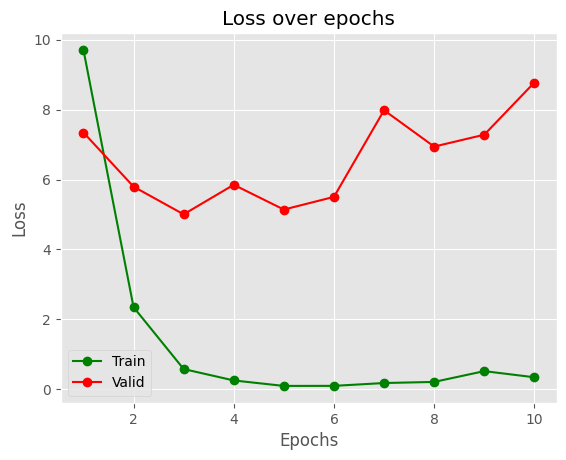

[codecarbon INFO @ 23:22:00] 
Graceful stopping: collecting and writing information.
Please Allow for a few seconds...
[codecarbon INFO @ 23:22:00] Energy consumed for RAM : 0.001074 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 23:22:00] Energy consumed for all GPUs : 0.001883 kWh. All GPUs Power : 9.749 W
[codecarbon INFO @ 23:22:00] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 23:22:00] 0.002957 kWh of electricity used since the begining.
[codecarbon INFO @ 23:22:00] Done!



Saving final model...


In [16]:
CNN_model = CNNSpeechClassifier(channel_inputs=1, num_channels1=16,
                                num_channels2=32, kernel_size=2,
                                kernel_pool=2, padding=0, num_classes=3)


trainer = MyTrainer(CNN_model)
trainer.train_loop(train_dataloader, val_dataloader, visual=True, epochs=5)

# Test

In [17]:
def load_components(checkpoint):


    epoch = checkpoint["epoch"]
    loss_fn = checkpoint["loss"]
    #loss_fn = nn.CrossEntropyLoss()

    model = CNNSpeechClassifier(channel_inputs=1, num_channels1=16,
                                num_channels2=32, kernel_size=2,
                                kernel_pool=2, padding=0, num_classes=3)


    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    model.to(device)

    return model, optimizer, epoch, loss_fn


Main

In [18]:
test_dir = "./Dataset/test/test"

test_data = SpeechDataset(test_dir, "librosa")
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)  # one is 4, 64, 862 - 4 despite batch size

best_checkpoint = torch.load("model_output/best_speech_cnn.pth", map_location=device)  # weird form of early stopping. Should add patience
final_checkpoint = torch.load("model_output/final_speech_cnn.pth", map_location=device)
model, optimizer, epoch, loss_fn = load_components(best_checkpoint)

acc, test_loss = evaluation(model, test_dataloader, loss_fn)

print(f"Best epoch {epoch}: test loss is {test_loss:.3f} | Accuracy is {acc:.2f}%")

Best epoch 3: test loss is 5.884 | Accuracy is 46.67%
